In [203]:
# Going to use Mellin transform stuff.. whacky!
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [221]:
diameter = 0.125
period = 200e-6
# modifications to the pscale (and hence wavelength range)
wl_unc = 0.1

In [222]:
N = 1024              # number of samples
dx = 0.004 * 10*10**(-9) # wavelength spacing, for ~ 1000 samples in 10 nm
# can just decrease the wavelength spacing...
fs = 1 / dx           # sampling frequency
freqs = np.fft.fftfreq(N, d=dx)

min_wavelength = 565e-9

# Desired frequency band (in Hz)
f_low = 0

max_wavelength = min_wavelength + dx*N

wl_bound = (max_wavelength - min_wavelength)*wl_unc

# should really get a pixel scale dependence thing here but i'm just gonna multiply be pscale min and max for now
max_spec_freq = 1*(np.sqrt(2)/period) * (diameter/(min_wavelength-wl_bound))

f_high = 2*max_spec_freq

In [234]:
key = jr.PRNGKey(70)

# Create a complex array of zeros
spectrum = np.zeros(N, dtype=np.complex64)

# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(N,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(N,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:N//2].set(spec[1:N//2])
    spec = spec.at[-(N//2)+1:].set(np.conj(spec[1:N//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)

def sinc_interp(xi, x, y, sample_interval):
    # xi: new points, x: original, y: filtered signal
    sinc_matrix = np.sinc((xi[:, None] - x[None, :]) / sample_interval)
    return sinc_matrix @ y  # shape: (len(xi),)

def const_Q_bandlimit(x, y, bandlimit):
    # requires uniformly spaced x
    # I think the issue is somehow, somewhere in here
    # when resampling back to original domain get
    # awefully 'spiky' signal.
    N = len(x)
    dx = x[1] - x[0]
    x_log = np.linspace(np.log(np.min(x)),np.log(np.max(x)),N)
    dx_log = x_log[1] - x_log[0]
    x_interp = np.exp(x_log)

    y_interp = sinc_interp(x_interp, x, y, dx)

    # make exact
    y_interp = y_interp * np.exp(x_log/2)

    y_interp_fft = np.fft.fft(y_interp)

    freqs_interp = np.fft.fftfreq(N, d=dx_log)
    
    mask = (np.abs(freqs_interp) > bandlimit)
    y_interp_fft_filtered = y_interp_fft.at[mask].set(0)
    y_interp_filtered = np.fft.ifft(y_interp_fft_filtered).real
    
    # make exact again..
    y_interp_filtered = y_interp_filtered * np.exp(-x_log/2)

    x_og_log = np.log(x)
    y_filtered = sinc_interp(x_og_log, x_log, y_interp_filtered, dx_log)
    
    # might need to resample to nyquist...
    # nevermind... that lowers the number of sample intervals...
    # max_spec_freq = bandlimit/x[0]

    # nyquist_sample_interval = 1/(2*max_spec_freq)

    # sample_interval = 0.4*nyquist_sample_interval #0.4 nyquist

    # N_x_nyquist = int(np.ceil((np.max(x)-np.min(x))/sample_interval))

    # x_nyquist = np.linspace(np.min(x), np.max(x), N_x_nyquist)
    # x_nyquist_log = np.log(x_nyquist)

    # y_filtered_nyquist = sinc_interp(x_nyquist_log, x_log, y_interp_filtered, dx_log)

    return y_filtered

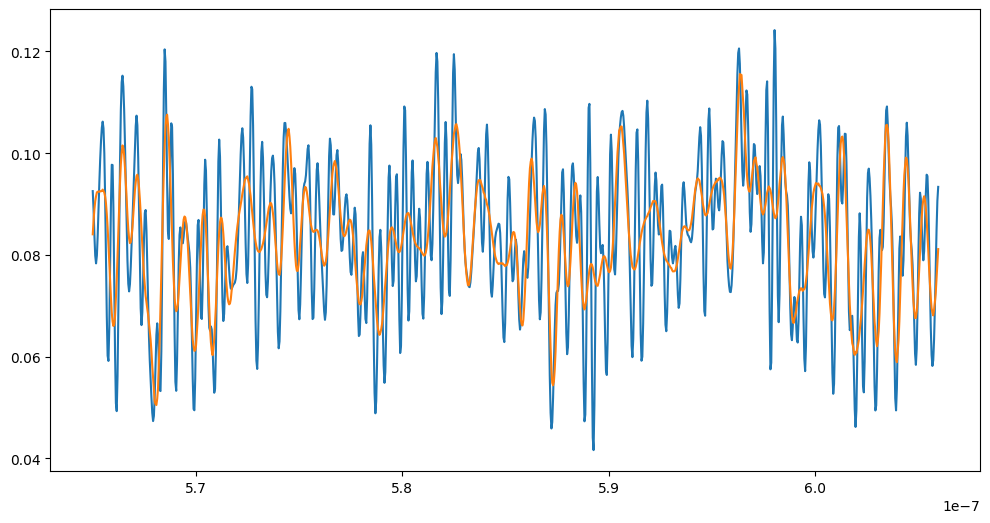

In [ ]:
signal = np.fft.ifft(spectrum).real

wavelengths = np.linspace(min_wavelength, max_wavelength, N)

bandlimit = np.sqrt(2)*diameter/(period)
signal_filtered = const_Q_bandlimit(wavelengths, signal, bandlimit)

#signal_filtered_dft = const_Q_dft(wavelengths, signal, bandlimit)

spectrum_filtered_bad = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
signal_filtered_bad = np.fft.ifft(spectrum_filtered_bad).real

if np.min(signal) <= 0:
    signal_filtered += -2*np.min(signal)
    signal_filtered_bad += -2*np.min(signal)
    #signal_filtered_dft += -2*np.min(signal)
    signal += -2*np.min(signal)

plt.figure(figsize=(12,6))
plt.plot(wavelengths, signal)
plt.plot(wavelengths, signal_filtered)
#plt.plot(wavelengths, signal_filtered_bad)
#plt.plot(wavelengths, signal_filtered_dft)
# plt.plot(wavelengths, signal_filtered - signal)
# plt.plot(wavelengths, signal_filtered_bad - signal)
# yep looks like that worked.
#plt.plot(wavelengths_interp)
plt.show()

In [280]:
nyquist_sample_interval = 1/(2*max_spec_freq)

sample_interval = 0.4*nyquist_sample_interval #quarter nyquist

n_wavelengths_sample = int(np.ceil((max_wavelength-min_wavelength+2*wl_bound)/sample_interval))

wavelengths_sample = np.linspace(min_wavelength - wl_bound, max_wavelength + wl_bound, n_wavelengths_sample)

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 40*(2.909*10**7)*(4/11)

difference = np.pi * 0.348
flux_renorm = flux #/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights=flux_rec)

source_filtered_bad = dl.PointSource(wavelengths, flux= flux_renorm, weights= signal_filtered_bad)

source_model = dl.PointSource(wavelengths_sample, flux=flux_renorm, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
assumed_pixel_scale = 0.375

# modifying the pixel scale by some random shift.
ps_shift = jr.uniform(key, minval=1-0.05*wl_unc, maxval=1+0.05*wl_unc)
psf_pixel_scale = assumed_pixel_scale * ps_shift
# just gonna do const pixel scale
psf_pixel_scale = assumed_pixel_scale

oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

# need an 'optics model' with assumed pixel scale
optics_model = dl.AngularOpticalSystem(wf_npixels, diameter, layers, psf_npixels, assumed_pixel_scale, oversample)

center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_filtered = dl.Telescope(optics, source_filtered)
telescope_filtered_bad = dl.Telescope(optics, source_filtered_bad)
telescope_model = dl.Telescope(optics_model, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)
sidelobescope_filtered_bad = dlT.SideLobeTelescope(telescope_filtered_bad, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

# model sure to include our assumed pixel scale
sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)
sidelobe_filtered_bad_raw = sidelobescope_filtered_bad.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)

sidelobe_poisson = jr.poisson(key, sidelobe_raw)

print(ps_shift)

Model time: 17.1432 seconds.
Model time: 16.6632 seconds.
Model time: 16.8337 seconds.
1.003723


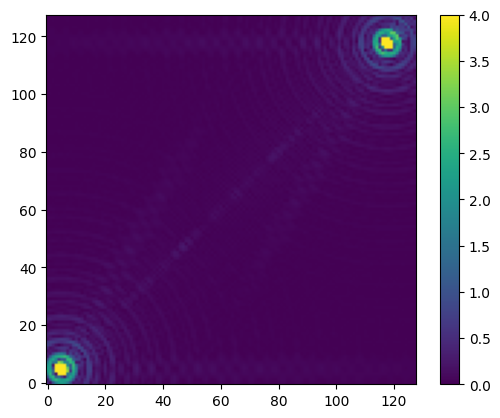

In [288]:
plt.imshow((np.abs(sidelobe_raw-sidelobe_filtered_bad_raw))**0.5, origin='lower', vmin=0,vmax=4)
#plt.xlim(20,100)
plt.colorbar()

plt.show()

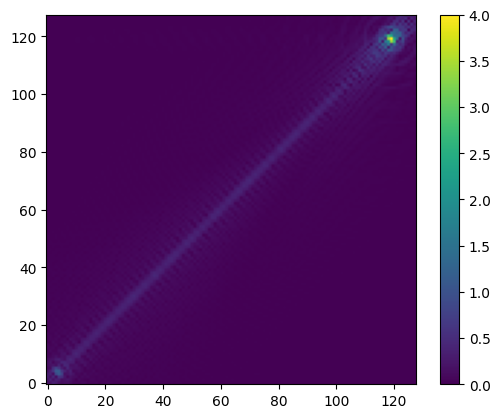

In [289]:
plt.imshow((np.abs(sidelobe_filtered_raw-sidelobe_raw))**0.5, origin='lower',vmin=0,vmax=4)
#plt.xlim(20,100)
plt.colorbar()
plt.show()

In [ ]:
# somehow this doesn't work.... not sure why
# my logic was faulty. need to do singular value decomp like dr pope said so.

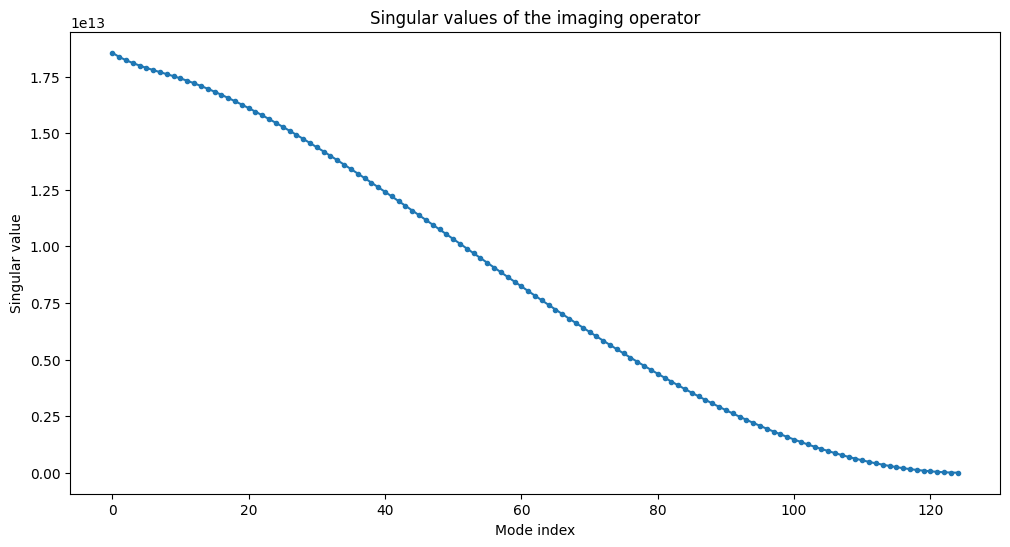

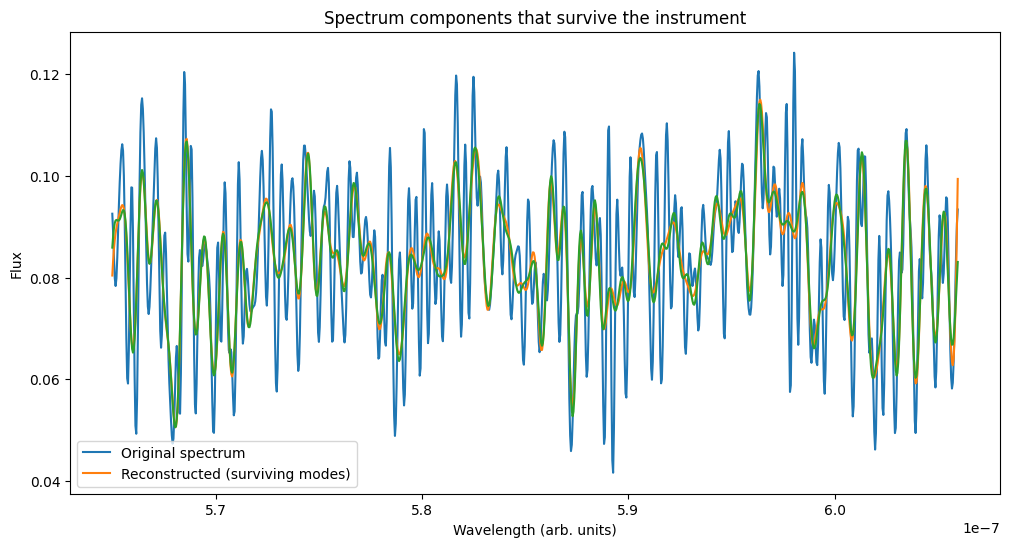

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# 1) Instrument parameters
D = diameter           # aperture diameter (arbitrary units)
P = period          # grating period (same units)
alpha = np.sqrt(2) / P

# 2) Wavelength grid and example spectrum
# N = 200
lam = wavelengths # np.linspace(0.5, 0.6, N)  # wavelengths from 0.5 to 0.6 (units)
# synthetic spectrum: two Gaussian peaks
flux = signal #np.exp(-((lam - 0.525)/0.005)**2) + 0.5 * np.exp(-((lam - 0.575)/0.003)**2)

# 3) Spatial grid along x
x_min = alpha * lam[0] - 5 * D * lam[0]
x_max = alpha * lam[-1] + 5 * D * lam[-1]
M = 125
x = np.linspace(x_min, x_max, M)

# 4) Build the K matrix: K[j, i] = PSF at x[j] for λ[i]
K = np.zeros((M, N))
for i, l in enumerate(lam):
    r = x - alpha * l
    beta = np.pi * D * np.abs(r) / l
    # Airy intensity PSF with 1/λ^2 scaling
    H = np.where(beta == 0, 1.0, (2 * j1(beta) / beta)**2)
    K[:, i] = H / l**2

# 5) Compute the SVD of K
U, S, Vt = np.linalg.svd(K, full_matrices=False)
V = Vt.T

# 6) Project the spectrum onto the singular vectors
c = V.T @ flux

# 7) Reconstruct only modes with singular value above threshold
threshold = 0.00000000000001 * S[0]
mask = S > threshold
flux_rec = V[:, mask] @ c[mask]

# 8) Plot singular values
plt.figure(figsize=(12,6))
plt.plot(S, '.-')
plt.title('Singular values of the imaging operator')
plt.xlabel('Mode index')
plt.ylabel('Singular value')

# 9) Plot original vs reconstructed (surviving) spectrum
plt.figure(figsize=(12,6))
plt.plot(lam, flux, label='Original spectrum')
plt.plot(lam, flux_rec, label='Reconstructed (surviving modes)')
plt.plot(lam, signal_filtered_bad)
plt.legend()
plt.title('Spectrum components that survive the instrument')
plt.xlabel('Wavelength (arb. units)')
plt.ylabel('Flux')
plt.show()

In [277]:
print(S)

[1.85515317e+13 1.83673064e+13 1.82226184e+13 1.80972874e+13
 1.79847019e+13 1.78811992e+13 1.77847043e+13 1.76934246e+13
 1.76046763e+13 1.75140251e+13 1.74173880e+13 1.73133166e+13
 1.72019997e+13 1.70839155e+13 1.69597132e+13 1.68297633e+13
 1.66945139e+13 1.65541541e+13 1.64090776e+13 1.62595332e+13
 1.61057288e+13 1.59479171e+13 1.57861613e+13 1.56209282e+13
 1.54521603e+13 1.52801693e+13 1.51050731e+13 1.49269867e+13
 1.47460067e+13 1.45626138e+13 1.43766000e+13 1.41883222e+13
 1.39976854e+13 1.38050196e+13 1.36103399e+13 1.34138867e+13
 1.32157640e+13 1.30159975e+13 1.28147344e+13 1.26122031e+13
 1.24084195e+13 1.22034831e+13 1.19974893e+13 1.17906873e+13
 1.15830015e+13 1.13744124e+13 1.11656109e+13 1.09561921e+13
 1.07465231e+13 1.05362790e+13 1.03259029e+13 1.01155171e+13
 9.90511703e+12 9.69482933e+12 9.48469770e+12 9.27491517e+12
 9.06542393e+12 8.85643820e+12 8.64792625e+12 8.44021210e+12
 8.23310583e+12 8.02690915e+12 7.82152354e+12 7.61712230e+12
 7.41387002e+12 7.211683

In [278]:
print(np.min(S))

4068639514.4381747


This looks ok, except for the fact that the singular values never quite reach zero. Sure they get close, but if I include components from every singular value in the spectrum it just fully gives the original spectrum. But I know that no 'spectral frequency' beyond sqrt(2)/P * D/lambda0 gets propagated, and I've already checked that. But this SVD seems to imply that you can get arbitrarily good frequency info so long as your noise floor is low enough? (singular values don't ever quite reach 0).